In [2]:
import tensorflow as tf 
import numpy as np 
import math 
import matplotlib.pyplot as plt 
import pandas as pd 
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

In [3]:
# Read in training data from train.csv 
dftrain = pd.read_csv('train.csv')
dftrainFeatureVector = dftrain.drop(['label'], axis=1)
trainFeatureVector = dftrainFeatureVector.values.astype(dtype = np.float32)
trainFeatureVectorConvoFormat = trainFeatureVector.reshape(42000, 28, 28, 1)

trainLabelsList = dftrain['label'].tolist()
ohtrainLabelTensor = tf.one_hot(trainLabelsList, depth=10)
ohtrainLabelNdarray = tf.Session().run(ohtrainLabelTensor).astype(dtype = np.float64)

# Read in testing data from test.csv 
dftest = pd.read_csv('test.csv')
testFeatureVector = dftest.values.astype(dtype = np.float32)
testFeatureVectorConvoFormat = testFeatureVector.reshape(28000, 28, 28, 1)

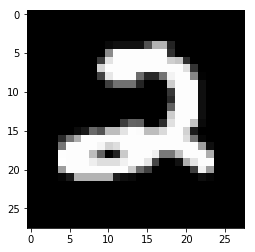

In [4]:
# Displaying from csv data 
pixels = testFeatureVectorConvoFormat[0].reshape((28,28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [5]:
# Construct tensorflow graph 

# Define tensorflow graph 
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_ = tf.placeholder(tf.float32, [None, 10])
lr = tf.placeholder(tf.float32)
pkeep = tf.placeholder(tf.float32)

K = 6 
L = 12
M = 24
N = 200 


W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))

W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

# The model
stride = 1  # output is 28x28
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

In [6]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predictions = tf.argmax(Y, 1)

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

In [7]:
# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

def getBatch(i, size, trainFeatures, trainLabels):
    startIndex = (i * size) % 42000
    endIndex = startIndex + size
    batch_X = trainFeatures[startIndex : endIndex]
    batch_Y = trainLabels[startIndex : endIndex]
    return batch_X, batch_Y

# You can call this function in a loop to train the model, 100 images at a time
def training_step(i):

    # training on batches of 100 images with 100 labels
    size = 100
    batch_X, batch_Y = getBatch(i, size, trainFeatureVectorConvoFormat, ohtrainLabelNdarray)

    # learning rate decay
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # compute training values
    if i % 100 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on batch_X and batch_Y (ie. on 100 pieces of data)
        '''
        a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, pkeep: 1.0})
        print(str(i) + ": training accuracy:" + str(a) + " training loss: " + str(c) + " (lr:" + str(learning_rate) + ")")

    # compute test values
    if i % 500 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on all of the data
        '''
        a, c = sess.run([accuracy, cross_entropy], {X: trainFeatureVectorConvoFormat[-10000:], Y_: ohtrainLabelNdarray[-10000:], pkeep: 1.0})
        print(str(i) + ": ********* test accuracy:" + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, pkeep: 0.75})

# Run number of iterations training the NN    
for i in range(10000+1): 
    training_step(i)

0: training accuracy:0.08 training loss: 10016.8 (lr:0.003)
0: ********* test accuracy:0.0741 test loss: 10146.0
100: training accuracy:0.93 training loss: 31.4235 (lr:0.0028585653310520707)
200: training accuracy:0.93 training loss: 26.0527 (lr:0.0027240285123042826)
300: training accuracy:0.93 training loss: 22.1612 (lr:0.0025960531316326675)
400: training accuracy:0.91 training loss: 29.335 (lr:0.0024743191839261473)
500: training accuracy:0.95 training loss: 15.3479 (lr:0.002358522270907074)
500: ********* test accuracy:0.9705 test loss: 9.13874
600: training accuracy:1.0 training loss: 3.09899 (lr:0.002248372839976982)
700: training accuracy:0.94 training loss: 23.7815 (lr:0.002143595460184269)
800: training accuracy:0.97 training loss: 5.8856 (lr:0.002043928133503354)
900: training accuracy:0.98 training loss: 5.86822 (lr:0.001949121639703143)
1000: training accuracy:1.0 training loss: 1.78846 (lr:0.0018589389131666372)
1000: ********* test accuracy:0.9853 test loss: 4.57442
1100

9000: ********* test accuracy:0.9998 test loss: 0.05779
9100: training accuracy:1.0 training loss: 0.0225541 (lr:0.00013064489271317272)
9200: training accuracy:1.0 training loss: 0.00192022 (lr:0.0001291503236594374)
9300: training accuracy:1.0 training loss: 0.00102822 (lr:0.00012772864559857617)
9400: training accuracy:1.0 training loss: 0.00633252 (lr:0.00012637630359491788)
9500: training accuracy:1.0 training loss: 0.000518583 (lr:0.00012508991608904985)
9500: ********* test accuracy:1.0 test loss: 0.00984504
9600: training accuracy:1.0 training loss: 0.0886038 (lr:0.0001238662664421581)
9700: training accuracy:1.0 training loss: 0.00928987 (lr:0.00012270229489275475)
9800: training accuracy:1.0 training loss: 0.00209362 (lr:0.00012159509090568058)
9900: training accuracy:1.0 training loss: 0.000900651 (lr:0.00012054188589425116)
10000: training accuracy:1.0 training loss: 0.0244367 (lr:0.00011954004629734786)
10000: ********* test accuracy:1.0 test loss: 0.0127942


In [ ]:
# Print the test accurscy on some data that was held out
a, c = sess.run([accuracy, cross_entropy], {X: trainFeatureVectorConvoFormat[-10000:], Y_: ohtrainLabelNdarray[-10000:], pkeep: 1.0})
print("\n ********* test accuracy:" + str(a) + " test loss: " + str(c))

# Get predictions on test data
p = sess.run([predictions], {X: testFeatureVectorConvoFormat, pkeep: 1.0})

# Write predictions to csv file
results = pd.DataFrame({'ImageId': pd.Series(range(1, len(p[0]) + 1)), 'Label': pd.Series(p[0])})
results.to_csv('results.csv', index=False)


 ********* test accuracy:1.0 test loss: 0.0128906
